# Credit Card Fraud Detection through Hybrid HDBScan and Isolation Forest 

In [2]:
## Logger configuration
from loguru import logger

logger.remove()

logger.add("logs/hyb_hdbscan.log",
           level = "INFO",
           format = "{time:HH:mm:ss} | {level} | {message}")

2

## Data Loading and Preparation

In [30]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data  = pd.read_csv("../creditcard.csv")

sampled_df, _ = train_test_split(data, 
                                test_size = 0.5, 
                                stratify = data['Class'], 
                                random_state = 42)


## Select either sampled or unsampled data
# df = data
df = sampled_df
df_orig = df.copy()

## Save labels for later, drop unneeded features  
label_df = pd.DataFrame({"Class": df["Class"]})
df.drop(columns = ["Class", "Time"], inplace = True)

## Scale the amount feature 
scaler = StandardScaler()
df['Amount'] = scaler.fit_transform(df[['Amount']])

print(f"Dataset shape: {df.shape}")

Dataset shape: (142403, 29)


## HDBSCAN Clustering

### Define HDBSCAN Functions

#### HDBSCAN Training Function

In [4]:
from sklearn.cluster import HDBSCAN
from time import time

def hdbscan_clustering(X, params, logging = True):
    
    """
    Inputs:
        X: a dataframe object with training features 
        params: a dictionary with model parameters
        logging: True or False on whether training information should be logged 
        
    Returns: 
        The cluster label outputs from hdbscan.fit_predict()
            
    This function clusters input data using HDBSCAN and returns cluster labels. 
    The logging parameter can be used to record training time information. 
    """
    
    ## Set n_jobs to use all available cores
    params["n_jobs"] = -1
    
    ## Cluster it up
    start_time = time()                        # Record start time
    hbdscan = HDBSCAN(**params)                # Instantiate model with input parameters
    cluster_labels = hbdscan.fit_predict(X)    # Assign Cluster Labels 
    end_time = time()                          # Record End Time  
    
    ## Record model training time and parameters used 
    if logging == True:
        total_training_time_seconds = end_time - start_time
        minutes, seconds = divmod(total_training_time_seconds, 60)
        formatted_time = f"{int(minutes):02}:{int(seconds):02}"
        logger.debug(f"HBDScan Model Trained | Train Time (Minutes): {formatted_time} | Parameters | {params} |")
    
    return cluster_labels

#### HDB Scan Cluster Analysis Function

In [27]:
def analyze_clusters(params, label_df, cluster_labels):
    
    """
    Parameters:
    - label_df: A dataframe object with a "Class" column
    - cluster_labels: The label outputs from hdbscan.fit_predict()

    For each set of parameters, records:
    - the parameters
    - the % noise
    - Count of fraud in clusters, and 
    - Number of clusters  
    
    Logs results in notebooks/hdbscan.log 
    """
    
    ## Adds cluster labels to common df with class labels 
    eval_df = label_df.copy()
    eval_df["Cluster"] = cluster_labels
    
    ## Cluster / Class Distribution Table 
    distribution = eval_df.groupby('Cluster')['Class'].value_counts().unstack(fill_value = 0)
    
    ## Assemble counts  
    cluster_count = eval_df["Cluster"].nunique()  
    total_noise_count = (eval_df["Cluster"] == -1).sum()
    total_fraud_count = (eval_df["Class"] == 1).sum()
    noise_fraud_count = distribution.loc[-1, 1]
    noise_pct = ((total_noise_count / eval_df.shape[0]) * 100).round(2)
    
    ## Results
    logger.info(f"Parameters: {params} | Clusters: {cluster_count} | Noise: {noise_pct}% | Fraud in cluster: {total_fraud_count - noise_fraud_count} | Fraud in noise: {noise_fraud_count}")

#### Plot UMAP Projection

In [24]:
import matplotlib.pyplot as plt
import umap
import umap.plot


def plot_umap_projection(data, labels, param_index):

    reducer = umap.UMAP()
    embedding = reducer.fit(data)
    
    umap.plot.points(embedding, 
                 labels = labels, 
                 theme = "fire", 
                 show_legend = False)
    
    plt.title(f"Fraud Data Cluster UMAP Projection {param_index}")
    plt.savefig(f"../graphs/cluster_umaps/UMAP Cluster Projection {param_index}",
            bbox_inches = 'tight')

#### Clustering Grid Search Function

- [HBDScan Parameters Documentation](https://hdbscan.readthedocs.io/en/latest/parameter_selection.html)


In [28]:
import itertools

def cluster_grid_search(X, param_grid, label_df):
    
    """
    Accepts X, a parameter grid, and a dataframe with class labels and conducts 
    a HDBScan model grid search. 
    
    Uses the defined hdbscan_clustering and analyze_clusters function to train, assess, and log data on each parameter set. 
    """
    
    # Extract parameters and generate all combinations 
    keys, values = zip(*param_grid.items())
    iter_param = [dict(zip(keys, combo)) for combo in itertools.product(*values)]
    
    
    # Execute Grid Search 
    combinations = len(iter_param)
    logger.info(f"Grid Search Initiated | Combinations to attempt: {combinations}")
    counter = 1
    
    for p in iter_param:
        logger.info(f"Search {counter} / {combinations}")
        cluster_labels = hdbscan_clustering(X, p, logging = False)
        analyze_clusters(p, label_df, cluster_labels)
        plot_umap_projection(X, cluster_labels, counter)
        counter += 1

### Run HDBSCAN Grid Search, Select Test Parameters
Considerations for selecting these parameters:
- Balance noise % and number of clusters
- Prioritize fraud in clusters 
- Conducting a sophisticated smell test

MemoryError: Unable to allocate 19.9 GiB for an array with shape (800, 800, 8362) and data type uint32

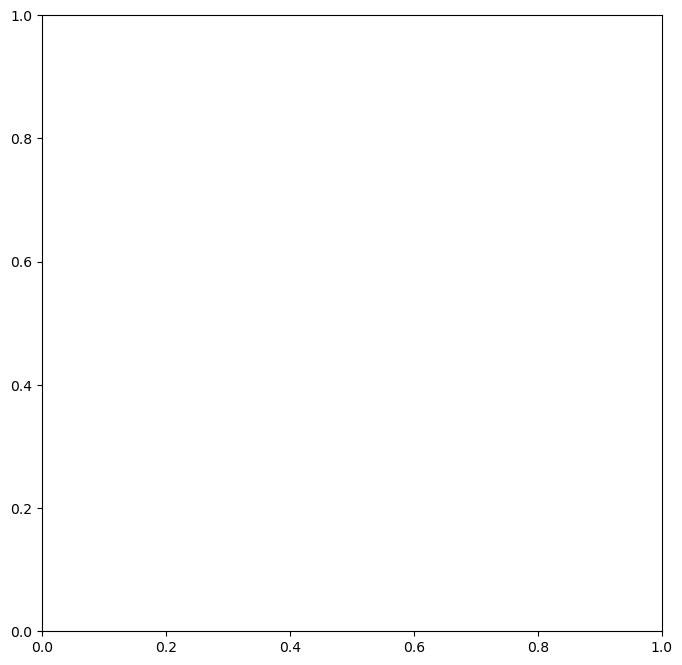

In [31]:
## Run Grid Search        
param_grid = {
        'min_cluster_size': [2],
        'min_samples': [1],
        'cluster_selection_epsilon': [1.5, 1.6],
    }

cluster_grid_search(df, param_grid, label_df)

### Test Selected Parameters

Key questions: 
- What percentage value of the fraud is captured in clusters? 
- How many clusters include fraud? 
- What is the cluster size distribution?

Create nice visualizations of each test parameter set. 

Then later, how effective is an isolation forest model at detecting fraud within each given cluster? 


In [ ]:
param_list = [

    {'min_cluster_size': 2,
     'min_samples': 1,
     'cluster_selection_epsilon': 1.5},
    
    {'min_cluster_size': 2,
     'min_samples': 1,
     'cluster_selection_epsilon': 1.6}
    ]

In [17]:
test_para = param_list[-2]
cluster_labels = hdbscan_clustering(df, test_para)

In [ ]:
def analyze_clusters(params, label_df, cluster_labels):
    
    """
    Parameters:
    - label_df: A dataframe object with a "Class" column
    - cluster_labels: The label outputs from hdbscan.fit_predict()

    For each set of parameters, records:
    - the parameters
    - the % noise
    - Count of fraud in clusters, and 
    - Number of clusters  
    
    Logs results in notebooks/hdbscan.log 
    """
    
    ## Adds cluster labels to common df with class labels 
    eval_df = label_df.copy()
    eval_df["Cluster"] = cluster_labels
    
    ## Cluster / Class Distribution Tables 
    distribution = eval_df.groupby('Cluster')['Class'].value_counts().unstack(fill_value = 0) 
    distribution["total"] = distribution[0] + distribution[1] 
    distribution = distribution.sort_values(by = 'total', ascending = False)
    
    dist_fraud = distribution[distribution[1] > 0]
    dist_no_fraud = distribution[distribution[1] == 0]
    
    
    ## Assemble counts  
    cluster_count = eval_df["Cluster"].nunique()  
    total_noise_count = (eval_df["Cluster"] == -1).sum()
    total_fraud_count = (eval_df["Class"] == 1).sum()
    noise_fraud_count = distribution.loc[-1, 1]
    noise_pct = ((total_noise_count / eval_df.shape[0]) * 100).round(2)
    
    ## Results
    results_info = f"Parameters: {params} | Clusters: {cluster_count} | Noise: {noise_pct}% | Fraud in cluster: {total_fraud_count - noise_fraud_count} | Fraud in noise: {noise_fraud_count}"
    print(results_info)
    
    return dist_fraud, dist_no_fraud

In [16]:
dist_fraud, dist_no_fraud = analyze_clusters(test_para, label_df, cluster_labels)

Parameters: {'min_cluster_size': 2, 'min_samples': 1, 'cluster_selection_epsilon': 1.5, 'n_jobs': -1} | Clusters: 3531 | Noise: 19.93% | Fraud in cluster: 51 | Fraud in noise: 23


In [ ]:
dist_fraud

Class,0,1,total
Cluster,,,
-1,8493,23,8516
2976,82,1,83
1886,61,1,62
3260,19,2,21
2856,14,1,15
57,4,8,12
15,0,4,4
23,0,4,4
2391,2,1,3


### Cluster Visualization

/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/dshebb/miniconda3/envs/py-3.12/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/home/dshebb/miniconda3/envs/

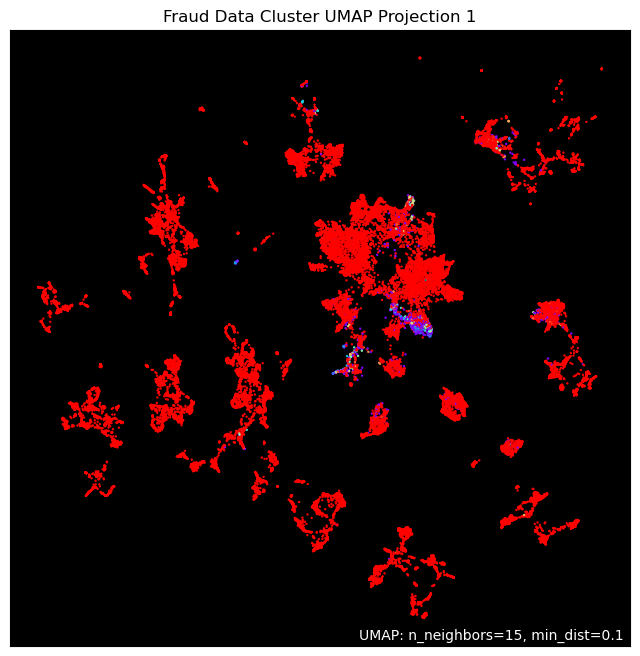

### Cluster Statistics

#### Cluster Size Histogram 
[matplotlib hist documentation](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html)

In [9]:
import matplotlib.pyplot as plt

def plot_cluster_histogram(label_df, cluster_labels, test_param, param_index):
    
    ## Create eval_df for testing 
    eval_df = label_df.copy()
    eval_df["Cluster"] = cluster_labels
    
    ## Cluster / Class Distribution Table 
    distribution = eval_df.groupby('Cluster')['Class'].value_counts().unstack(fill_value = 0)
    print(distribution)
    
    ## Math 
    ### Cluster Counts
    cluster_count = eval_df["Cluster"].nunique()  
    clusters_with_fraud = len(distribution[distribution[1] > 0]) - 1   # Minus one to not count fraud in noise 
    clusters_with_1_fraud = len(distribution[distribution[1] == 1])
    
    ### Noise percentage, amount of fraud in noise 
    total_noise_count = (eval_df["Cluster"] == -1).sum()
    noise_pct = ((total_noise_count / eval_df.shape[0]) * 100).round(2)
    noise_fraud_count = distribution.loc[-1, 1]
    
    ### Average cluster size 
    cluster_sizes = (eval_df["Cluster"].value_counts()).iloc[1:]    # Drop the noise 
    avg_cluster_size = cluster_sizes.mean().round()
    
    
    ## Plot Histogram 
    plt.figure(figsize = (10, 6))
    plt.tight_layout()
    
    ### Use 50 unit bins, set x limit to account for bin size and range
    bins = range(0, cluster_sizes.max() + 50, 50) 
    cluster_sizes.hist(bins=bins)
    plt.xlim(50, 800)
    
    ### Plot and axis labels  
    plt.title(f"HDBScan Cluster Size Histogram {param_index}")
    plt.xlabel('Cluster Population')
    plt.ylabel('Cluster Count')
    
    ### Parameter Text Box in Top Right 
    params_title = r"$\bf{Parameters}$" + "\n"
    params_text = "\n".join([f"{key}: {value}" for key, value in test_param.items()])

    plt.text(x = 1.05, 
            y = .95, 
            s = params_title + params_text, 
            ha = 'left',                     # Horizontal Alignment 
            va = 'top',                      # Vertical Alignment 
            transform = plt.gca().transAxes, 
            fontsize = 10) 
    
    ### Details Text Box in Middle Right 
    details_title = r"$\bf{Cluster\ Details}$" + "\n"
    details_text = f"Clusters: {cluster_count}\nAvg Cluster Size: {avg_cluster_size}\nNoise: {noise_pct}%\nClusters with Fraud: {clusters_with_fraud}\nClusters with >0 Fraud: {clusters_with_1_fraud}\nNoise count: {total_noise_count}\n{noise_fraud_count}"

    plt.text(x = 1.05, 
            y = .5, 
            s = details_title + details_text, 
            ha = 'left',                     # Horizontal Alignment 
            va = 'top',                      # Vertical Alignment 
            transform = plt.gca().transAxes, 
            fontsize = 10) 
    
    plt.savefig(f"../graphs/cluster_histograms/HDBScan Cluster Size Histogram {param_index}",
                bbox_inches='tight')
#     plt.show()

    ## Log Results 
#     logger.info(f"Clusters: {cluster_count} | Avg Cluster Size: {avg_cluster_size} | Noise: {noise_pct}% | Clusters with Fraud: {clusters_with_fraud} | Clusters with 1 Fraud: {clusters_with_1_fraud}")


Class        0   1
Cluster           
-1          27   5
 0           2   0
 1           0   2
 2           0   2
 3           2   0
 4           0   2
 5           2   0
 6           2   0
 7           2   0
 8           3   0
 9           0   2
 10          0   3
 11          2   0
 12          3   0
 13          3   6
 14          5   0
 15      42590  52
 16          4   0


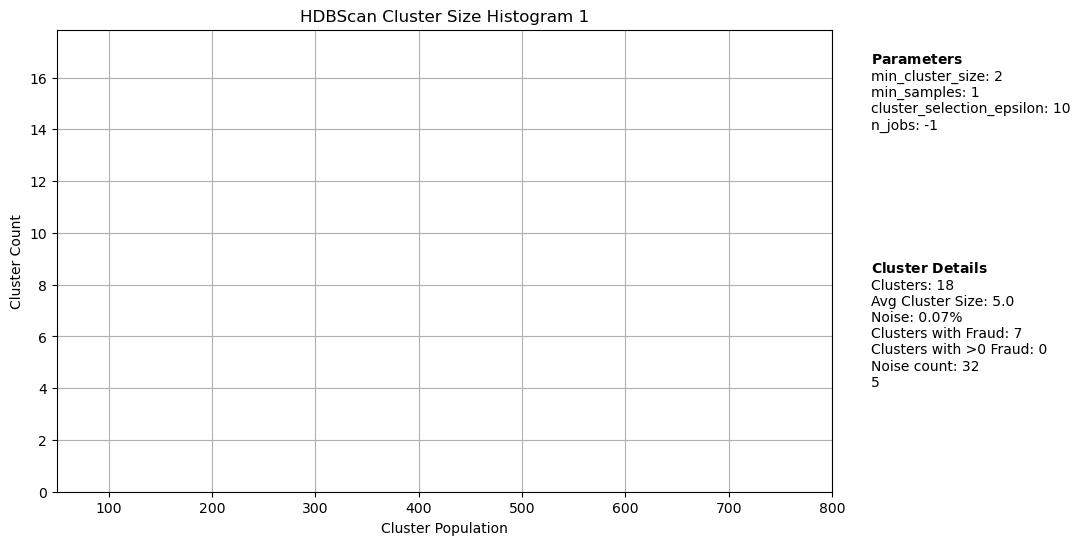

In [10]:
plot_cluster_histogram(label_df, cluster_labels, test_param, param_index = 1)

In [ ]:
param_index = 1

for param in [test_param]:
    clusters = hdbscan_clustering(hdb_df, param)
    plot_cluster_histogram(label_df, clusters, test_param, param_index)
    plot_umap_projection(hdb_df, clusters, param_index)
    param_index += 1

### Applying Isolation Forest Models 

Now that we have acceptable clustering, we can attempt a more granular application of isolation forest outlier detection. 

To attempt: 
- Normal train / test split 
- Split data by day, use the more normal day to train

## Combine data with cluster labels

In [ ]:
iso_df = df.copy()

iso_df["Cluster"] = clusters

In [ ]:
from sklearn.ensemble import IsolationForest


def train_isofor(X, y, parameters):

    # Split the data into training set and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    # Determine contamination rate
    contamination_rate = y_train.sum() / len(y_train) 
    params["contamination"] = contamination_rate

    # Train model 
    model = IsolationForest(**params, n_jobs = -1)
    model.fit(X_train)
    
    # Anomaly score, lower is more anomalous
    y_pred_scores = model.decision_function(X_test)  
    y_pred = model.predict(X_test)                   

    # -1 for anomaly, 1 for normal
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    return y_test, y_pred, params

In [ ]:
params = {"n_estimators": 100, 
          "random_state": 42} 

for c in clusters:
    
    
    

